In [1]:
import neuroseries as nts

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import scipy.signal
import scipy.stats

import bk.load
import bk.plot
import bk.compute
import bk.signal

from scipy.stats import gaussian_kde


import itertools

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [3]:
def all_fr(base_folder,local_path,*args,**kwargs):
    bk.load.current_session_linux(base_folder,local_path)
    neurons, metadata = bk.load.spikes()

    states = bk.load.states(True)

    df = {}
    for state_name,state in states.items():
        fr = []
        for n in neurons:
            fr.append(len(n.restrict(state))/state.tot_length('s'))
        df.update({state_name:fr})
    return pd.concat((metadata,pd.DataFrame(df)),1)

In [4]:
def merge(batch):

    df = pd.DataFrame()
    for sess,b in batch.items():
        df = pd.concat((df,b))
    return df

In [5]:
def ratio(x,y):
    if x+y == 0:
        return 0
    return (x-y) / (x+y)

In [7]:
def plot_kde(x,y,ax = None):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    if ax is None:
        _,ax = plt.subplots(1,1)
        
    ax.scatter(x, y, c=z, s=0.05)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect('equal')

    ax.axvline(0,color = 'red',linewidth = 0.5)
    ax.axhline(0,color = 'red',linewidth = 0.5)

In [8]:
batch, metadata = bk.load.batch(all_fr)

100%|██████████| 61/61 [03:09<00:00,  3.11s/it]

['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
Batch finished in 189.80302476882935
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
6.557377049180328 %


In [10]:
all_fr = merge(batch)

In [11]:
regions = ['Hpc', 'BLA']
types = ['Pyr', 'Int']
states = ['NREM', 'WAKE_HOMECAGE', 'REM']


ratios = {}
for stru, t, state_1, state_2 in itertools.product(regions, types, states, states):
    if stru not in ratios: ratios[stru] = {}   
    if t not in ratios[stru]: ratios[stru][t] = {}
    if state_1 not in ratios[stru][t]: ratios[stru][t][state_1] = {}
    if state_2 not in ratios[stru][t][state_1]: ratios[stru][t][state_1][state_2] = []
    
    for a, b in zip(all_fr[state_1][(all_fr.Region == stru) & (all_fr.Type == t)], all_fr[state_2][(all_fr.Region == stru) & (all_fr.Type == t)]):
        ratios[stru][t][state_1][state_2].append(ratio(a, b))

Hpc Pyr
0
Hpc Int
0
BLA Pyr
1
BLA Int
1


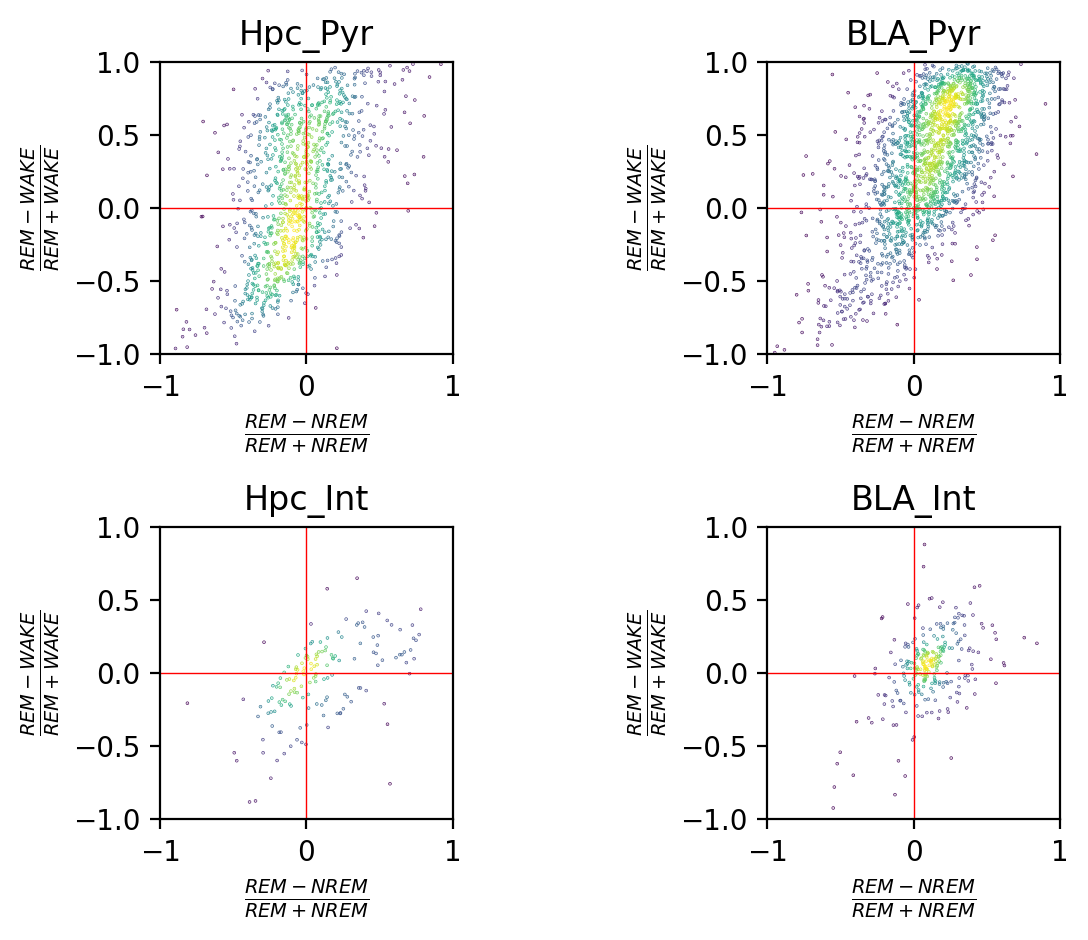

In [12]:
fig, axes = plt.subplots(2, len(regions), dpi=200)
i=0
for stru,t in itertools.product(regions,types):
    print(stru,t)
    print(i%2)
    if t == 'Pyr': line = 0
    else: 
        line = 1
        
    plot_kde(ratios[stru][t]['REM']['NREM'],
            ratios[stru][t]['REM']['WAKE_HOMECAGE'], axes[line, i])
    axes[line, i].set_title(stru+'_'+t)
    axes[line, i].set_xlabel('$\\frac{REM-NREM}{REM+NREM}$')
    axes[line, i].set_ylabel('$\\frac{REM-WAKE}{REM+WAKE}$')
    if t=='Int': i +=1
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/Ratio.svg')


In [14]:
len(ratios['BLA']['Int']['REM']['NREM'])

261